# ACP Project - Model Evaluation

## Setup

In [68]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import shap

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from utils.evaluation import f2_score, METRICS, evaluate, evaluate_from_pred, with_sampling_strategies, spotCheckCV, spotCheckDatasets, F2TabNet, joint_plot
from utils.isolation_forest_wrapper import IsolationForestWrapper
%aimport utils.evaluation

In [70]:
class Notebook:
    # Remember to create these directories!
    IMAGE_DIR = "images/critical_event_48"
    MODEL_DIR = "models/critical_event_48"
    OUTCOME_PRESET = "CriticalEvent48"

    SAVE_MODELS = True
    SAVE_IMAGES = True
    RUN_HYPERPARAMETERS = True
    HYPERPARAMETERS_NJOBS = -1
    UNDERSAMPLING_STRATEGY = 0.1
    SHAP_PLOTS_MAXDISPLAY = 20

    MODELS = {}
    EXPLAINERS = {}
    EVAL_RESULTS = {}
    TUNED_RESULTS = {}


In [71]:
try:
    os.makedirs(Notebook.IMAGE_DIR)
    os.makedirs(Notebook.MODEL_DIR)
except FileExistsError:
    pass

In [72]:
def restore():
    with open(f'{Notebook.MODEL_DIR}/models.bin', 'rb') as file:
        Notebook.MODELS = pickle.load(file)

    with open(f'{Notebook.MODEL_DIR}/explainers.bin', 'rb') as file:
        Notebook.EXPLAINERS = pickle.load(file)

    with open(f'{Notebook.MODEL_DIR}/eval_results.bin', 'rb') as file:
        Notebook.EVAL_RESULTS = pickle.load(file)

    with open(f'{Notebook.MODEL_DIR}/tuned_results.bin', 'rb') as file:
        Notebook.TUNED_RESULTS = pickle.load(file)

    with open(f'{Notebook.MODEL_DIR}/sets.bin', 'rb') as file:
        sci_train_idx, sci_test_idx = pickle.load(file)

### Dataset

In [73]:
from dataset import SCIData, SCICols
%aimport dataset

outcome_options = {
    'CriticalEvent24': (lambda x: x.derive_critical_event(within=1), 'CriticalEvent'),
    'CriticalEvent48': (lambda x: x.derive_critical_event(within=2), 'CriticalEvent'),
    'CriticalEventAny': (lambda x: x.derive_critical_event(within=999), 'CriticalEvent'),
    'CriticalCare24': (lambda x: x.derive_critical_care(within=1), 'CriticalCare'),
    'CriticalCare48': (lambda x: x.derive_critical_care(within=2), 'CriticalCare'),
    'CriticalCareAny': (lambda x: x.derive_critical_care(within=999), 'CriticalCare'),
    'Death24': (lambda x: x.derive_death_within(within=1, col_name="DiedWithin24h"), "DiedWithin24h"),
    'Death48': (lambda x: x.derive_death_within(within=2, col_name="DiedWithin48h"), "DiedWithin48h"),
    'DeathAny': (lambda x: x, "DiedDuringStay"),
    'Death30': (lambda x: x, 'DiedWithin30Days'),
    'LOS24': (lambda x: x.derive_long_los(over=1), 'LongLOS'),
    'LOS48': (lambda x: x.derive_long_los(over=2), 'LongLOS'),
    'LOS7': (lambda x: x.derive_long_los(over=7), 'LongLOS'),
}

sci = SCIData.load('data/sci_processed.h5').fix_readmissionband()
sci = outcome_options[Notebook.OUTCOME_PRESET][0](sci)
Notebook.OUTCOME = outcome_options[Notebook.OUTCOME_PRESET][1]


In [74]:
def drop_exclusive_cols(X1, X2):
    exclusive_cols = set(X1.columns) ^ set(X2.columns)
    X1.drop(exclusive_cols, axis=1, errors="ignore", inplace=True)
    X2.drop(exclusive_cols, axis=1, errors="ignore", inplace=True)

def ensure_categorical_overlap(X1, X2, cols_to_check):
    for col in cols_to_check:
        col = X1.columns[col]
        X1_uniq, X2_uniq = X1[col].unique(), X2[col].unique()
        to_remove = list(set(X1_uniq) ^ set(X2_uniq))
        repl = list(set(X1_uniq) & set(X2_uniq))[0]
        X1.loc[X1[col].isin(to_remove), col] = repl
        X2.loc[X2[col].isin(to_remove), col] = repl

In [154]:
from sklearn.model_selection import train_test_split

scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .raw_news()
    .mandate_news()
    .mandate_blood()
    .augment_hsmr()
)

sci_train, sci_test = train_test_split(
    scii, test_size=0.33, random_state=42, stratify=scii[Notebook.OUTCOME]
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

# Drop HSMR_15 as there is only 1 in the entire dataset, making a split impossible
(X_train, y_train), (X_test, y_test) = (
    sci_train.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True
    ),
    sci_test.encode_ccs_onehot().xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, dropna=False, fillna=True
    ),
)
categorical_cols_idx, categorical_cols_dims = X_train.describe_categories()
drop_exclusive_cols(X_train, X_test)
ensure_categorical_overlap(X_train, X_test, categorical_cols_idx)

# Mandated vitals, Categorical diagnoses (main only)
(X_train_if, y_train_if), (X_test_if, y_test_if) = (
    sci_train.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
    sci_test.drop(SCICols.diagnoses[1:], axis=1).xy(
        outcome=Notebook.OUTCOME, ordinal_encoding=True, fillna=True
    ),
)
drop_exclusive_cols(X_train_if, X_test_if)

(X_train_lgbm, y_train_lgbm), (X_test_lgbm, y_test_lgbm) = (
    sci_train.encode_ccs_onehot().xy(outcome=Notebook.OUTCOME, fillna=True),
    sci_test.encode_ccs_onehot().xy(outcome=Notebook.OUTCOME, fillna=True),
)
drop_exclusive_cols(X_train_lgbm, X_test_lgbm)
ensure_categorical_overlap(X_train_lgbm, X_test_lgbm, categorical_cols_idx)

(X_train_tn, X_valid_tn, y_train_tn, y_valid_tn) = train_test_split(
    X_train.to_numpy(),
    y_train.to_numpy(),
    stratify=y_train,
    test_size=0.33,
    random_state=42,
)

(X_train_news, y_train_news), (X_test_news, y_test_news) = (
    sci_train.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
    sci_test.xy(
        outcome=Notebook.OUTCOME, x=SCICols.news_data_raw, dtype=float, fillna=True
    ),
)
drop_exclusive_cols(X_train_news, X_test_news)


### Tuning

In [7]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


## Models

### Baseline (NEWS)

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.975758,0.176471,0.103448,0.722266,0.130435,0.112782


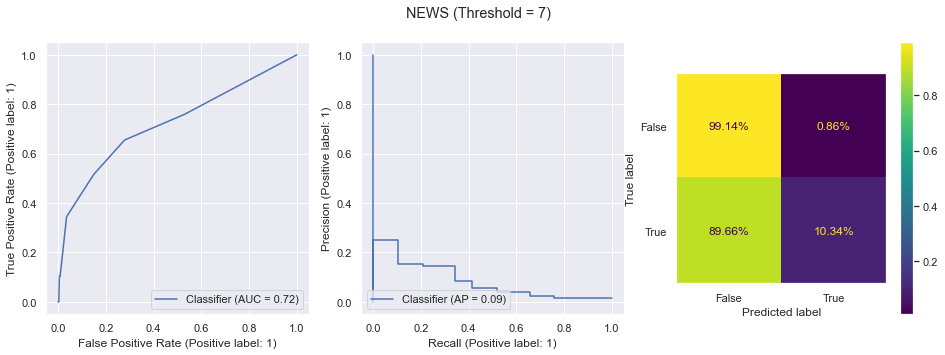

In [8]:
Notebook.EVAL_RESULTS["Baseline (NEWS)"] = evaluate_from_pred(
    y_test,
    y_pred=(sci.loc[sci_test.index].c_NEWS_score >= 7),
    y_pred_proba=(sci.loc[sci_test.index].c_NEWS_score),
    plot_title="NEWS (Threshold = 7)",
    save=f"{Notebook.IMAGE_DIR}/baseline_news.png" if Notebook.SAVE_IMAGES else None,
)


### Logistic Regression (NEWS only)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Model,0.846718,0.070811,0.669261,0.128071,0.248771,0.819662,0.789-0.849


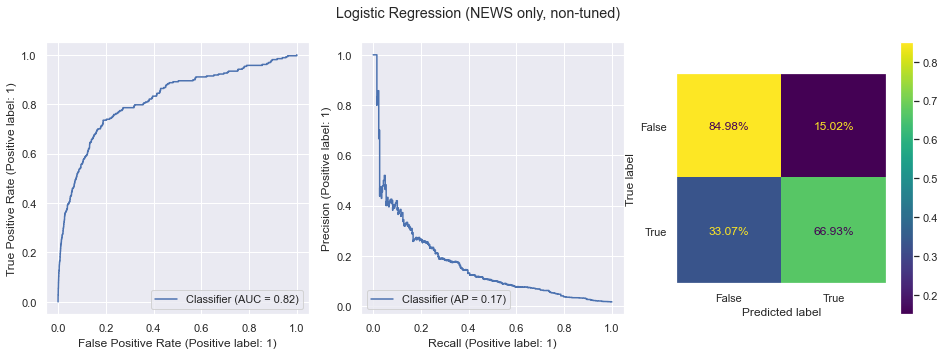

In [155]:
from sklearn.linear_model import LogisticRegression

modelkey = "Logistic Regression (NEWS only)"
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42).fit(
    X_train_news, y_train_news
)
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_news,
    y_test_news,
    plot_title="Logistic Regression (NEWS only, non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
)


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.607273,0.028919,0.655172,0.724095,0.055394,0.122898


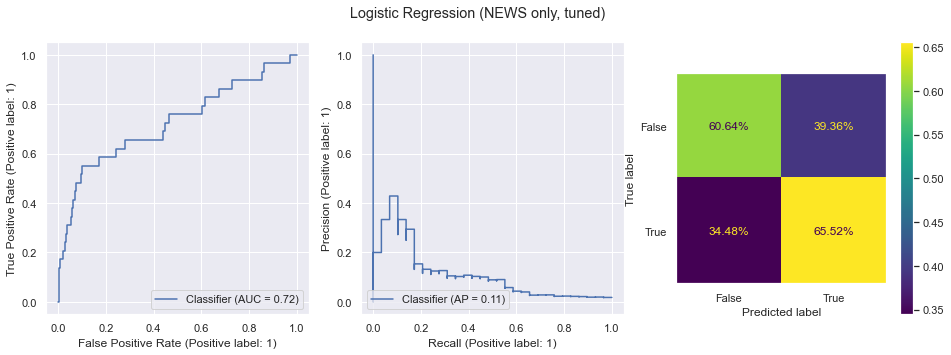

In [10]:
threshold = get_threshold(y_train_news, model.predict_proba(X_train_news)[:, 1],)

y_pred_proba = model.predict_proba(X_test_news)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_news,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (NEWS only, tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_news.png"
    if Notebook.SAVE_IMAGES
    else None,
)



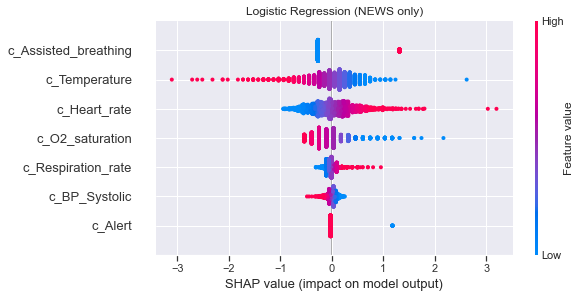

In [11]:
explainer = shap.LinearExplainer(model, X_train_news, feature_perturbation='correlation_dependent')
shap_values = explainer(X_test_news)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression_news.png",
        bbox_inches="tight",
    )


In [ ]:
fig = shap.plots.bar(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Logistic Regression (NEWS only)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression_news.png",
        bbox_inches="tight",
    )


### Logistic Regression

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Model,0.867138,0.093535,0.793774,0.16735,0.317856,0.898788,0.899 (0.873-0.924)


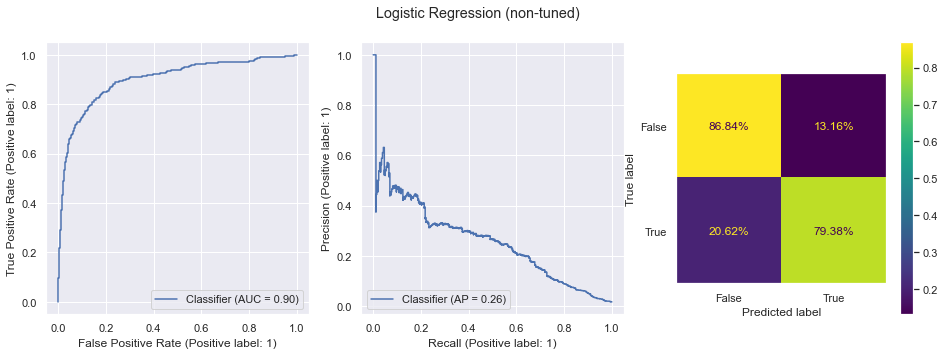

In [81]:
modelkey = "Logistic Regression"
model = LogisticRegression(max_iter=10000, class_weight="balanced").fit(
    X_train, y_train
)

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test,
    y_test,
    plot_title="Logistic Regression (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
)

Notebook.MODELS[modelkey] = model


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.920606,0.113636,0.517241,0.880087,0.186335,0.302419


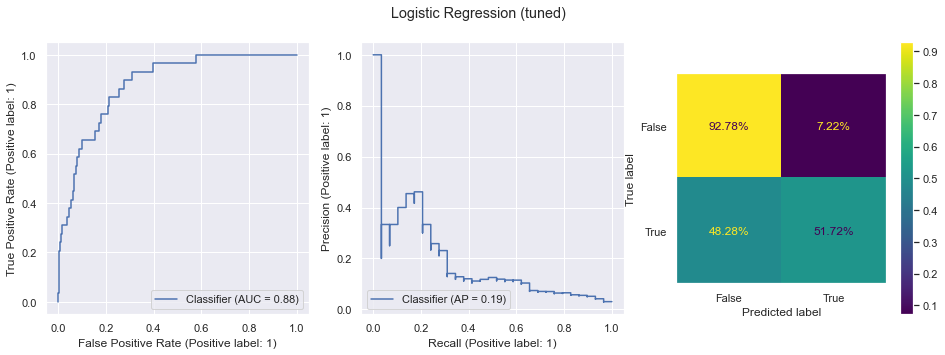

In [13]:
threshold = get_threshold(y_train, model.predict_proba(X_train)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Logistic Regression (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
)


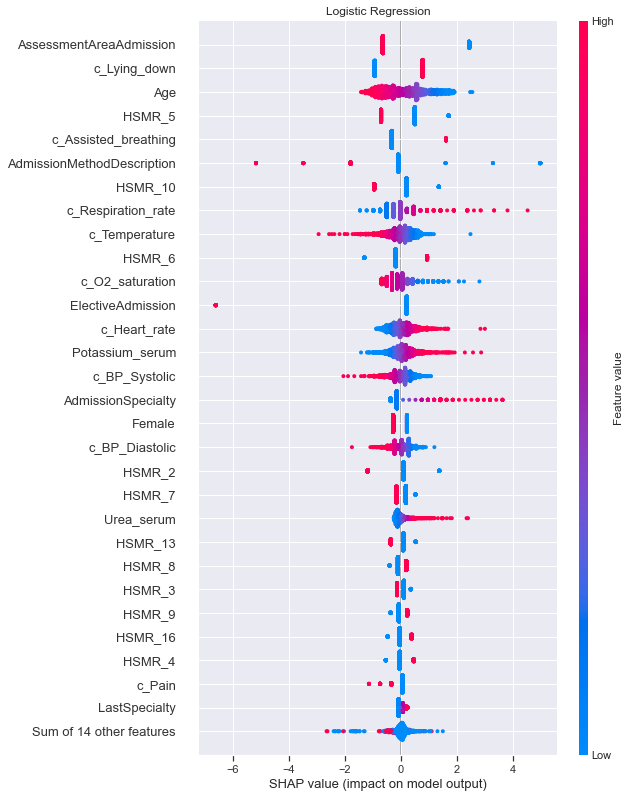

In [14]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation='correlation_dependent')
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight"
    )


In [ ]:
fig = shap.plots.bar(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logistic_regression.png", bbox_inches="tight"
    )


### Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "Random Forest"
model = ImbPipeline(
    steps=[
        (
            "undersampling",
            RandomUnderSampler(sampling_strategy=Notebook.UNDERSAMPLING_STRATEGY),
        ),
        ("randomforest", RandomForestClassifier()),
    ]
).fit(X_train.to_numpy(), y_train)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    plot_title="Random Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
)



MemoryError: Unable to allocate 2.28 GiB for an array with shape (9999, 30558) and data type float64

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.755758,0.058962,0.862069,0.855847,0.110375,0.231481


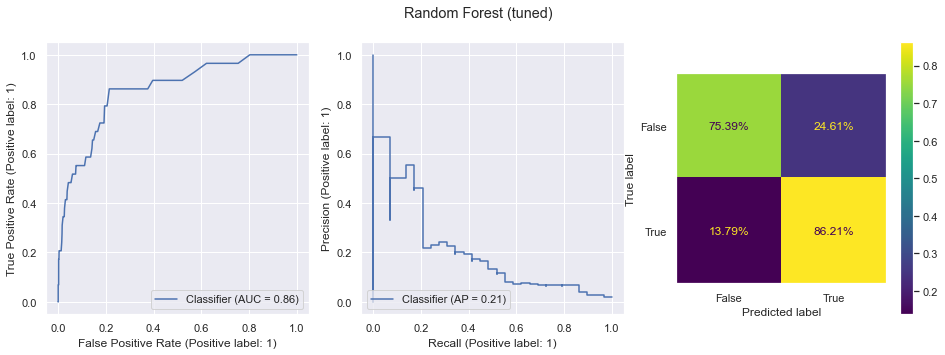

In [16]:
threshold = get_threshold(y_train, model.predict_proba(X_train.to_numpy())[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="Random Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_random_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
)


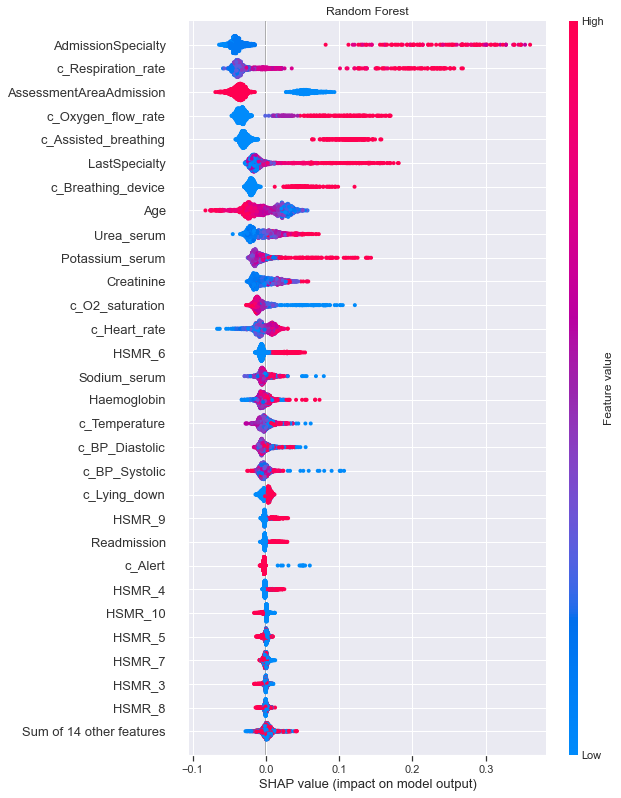

In [17]:
explainer = shap.TreeExplainer(model["randomforest"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_random_forest.png", bbox_inches="tight"
    )


In [ ]:
fig = shap.plots.bar(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Random Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_random_forest.png", bbox_inches="tight"
    )


### XGBoost

{'XGB__scale_pos_weight': 1}


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.930303,0.109091,0.413793,0.883958,0.172662,0.265487


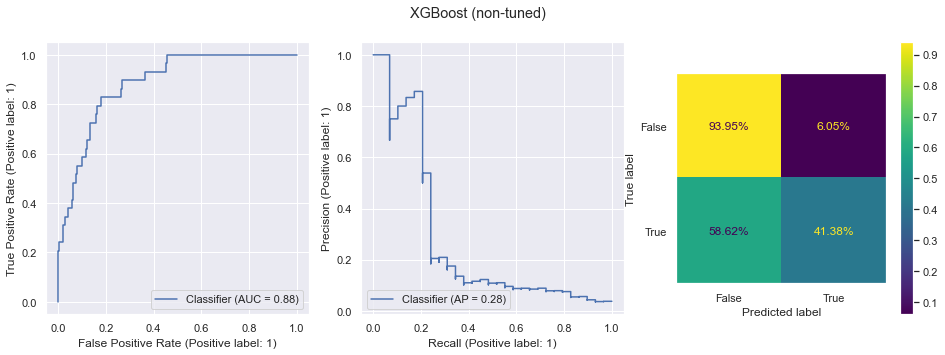

In [18]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

param_grid = {
    "XGB__scale_pos_weight": np.arange(1, 50, 10),
    #  'undersampling__sampling_strategy': np.arange(0.1, 0.5, 0.1)
}

modelkey = 'XGBoost'
model = ImbPipeline(
    steps=[
        (
            "undersampling",
            RandomUnderSampler(sampling_strategy=Notebook.UNDERSAMPLING_STRATEGY),
        ),
        (
            "XGB",
            XGBClassifier(
                tree_method="hist",
                enable_categorical=True,
                subsample=0.85,
                scale_pos_weight=31,
                n_estimators=140,
                max_depth=13,
                learning_rate=0.05,
                colsample_bytree=0.7,
                colsample_bylevel=0.9,
            ),
        ),
    ]
)

if Notebook.RUN_HYPERPARAMETERS:
    fitted = GridSearchCV(model, param_grid, n_jobs=Notebook.HYPERPARAMETERS_NJOBS, scoring='recall').fit(
        X_train, y_train
    )
    model = fitted.best_estimator_
    print(fitted.best_params_)
else:
    model = model.fit(X_train, y_train)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test,
    y_test,
    "XGBoost (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_xgboost.png" if Notebook.SAVE_IMAGES else None,
)


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.817576,0.075,0.827586,0.883958,0.137536,0.275229


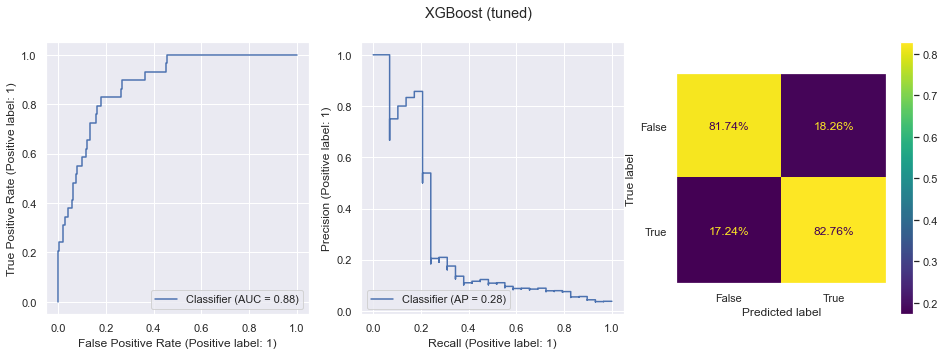

In [19]:
threshold = get_threshold(y_train, model.predict_proba(X_train)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > 1 - threshold, 1, 0)

# Produce scores
Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="XGBoost (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_xgboost.png"
    if Notebook.SAVE_IMAGES
    else None,
)


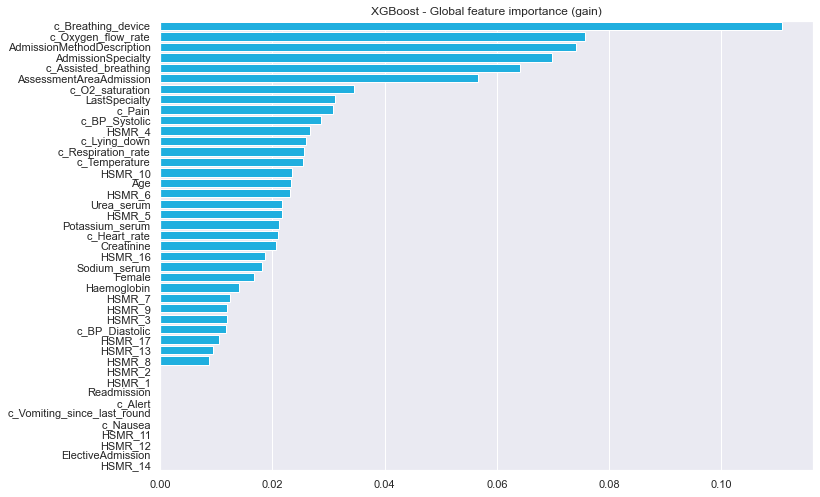

In [20]:
sorted_idx = model["XGB"].feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model["XGB"].feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("XGBoost - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_xgboost.png", bbox_inches="tight")



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


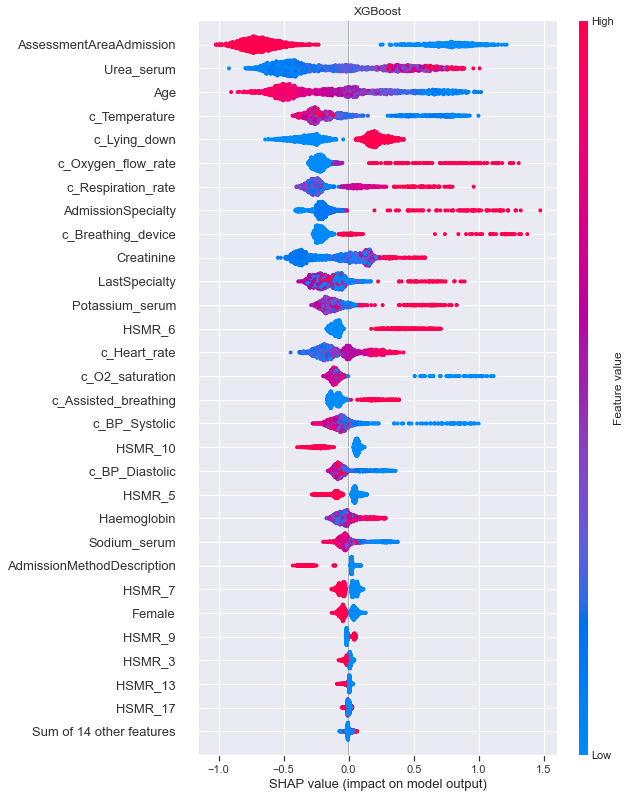

In [21]:
explainer = shap.TreeExplainer(model["XGB"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_xgboost.png", bbox_inches="tight")


In [ ]:
fig = shap.plots.bar(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("XGBoost")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_xgboost.png", bbox_inches="tight")


### LightGBM

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Model,0.927155,0.160317,0.785992,0.266315,0.441434,0.932375,0.914-0.949


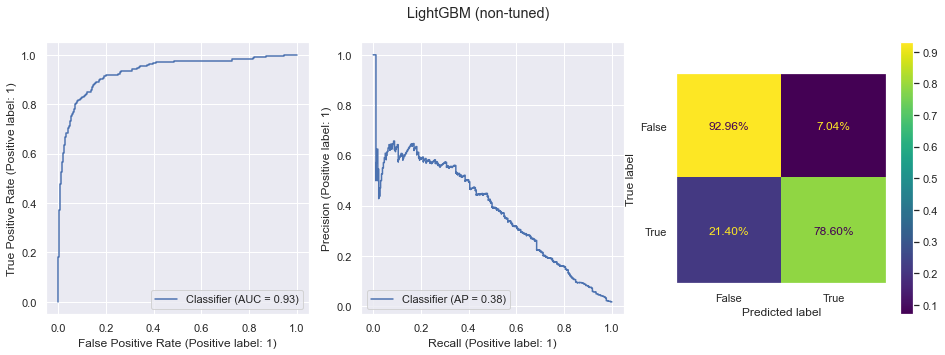

In [120]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

modelkey = "LightGBM"
model = ImbPipeline(
    steps=[
        (
            "undersampling",
            RandomUnderSampler(sampling_strategy=Notebook.UNDERSAMPLING_STRATEGY),
        ),
        ("lightgbm", LGBMClassifier(metric=["l2", "auc"], is_unbalance=True)),
    ]
).fit(X_train_lgbm.copy(), y_train_lgbm)


Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_lgbm.copy(),
    y_test_lgbm,
    plot_title="LightGBM (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_lightgbm.png" if Notebook.SAVE_IMAGES else None,
)


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.715152,0.050916,0.862069,0.852837,0.096154,0.205931


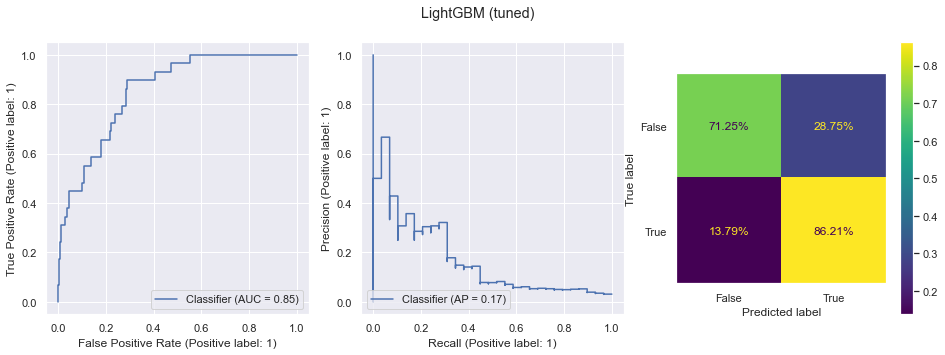

In [23]:
threshold = get_threshold(y_test_lgbm, model.predict_proba(X_test_lgbm)[:, 1],)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test_lgbm)[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_lgbm,
    y_pred,
    y_pred_proba,
    plot_title="LightGBM (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_lightgbm.png"
    if Notebook.SAVE_IMAGES
    else None,
)


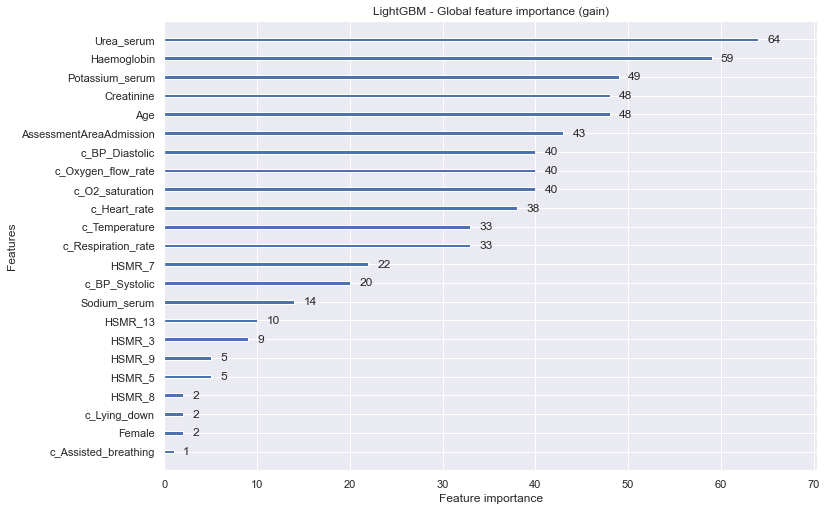

In [24]:
import lightgbm as lgb

fig = lgb.plot_importance(model["lightgbm"])
fig.set_title("LightGBM - Global feature importance (gain)")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/global_weights_lightgbm.png", bbox_inches="tight"
    )


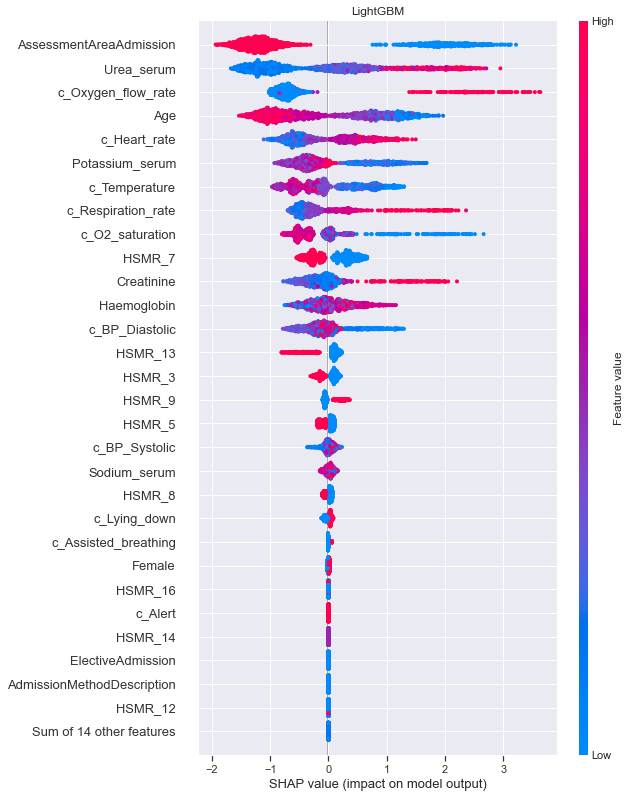

In [25]:
explainer = shap.TreeExplainer(model["lightgbm"])
shap_values = explainer(X_test)
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


In [ ]:
fig = shap.plots.bar(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight")

### Isolation Forest

,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.920606,0.101562,0.448276,0.790359,0.165605,0.266393


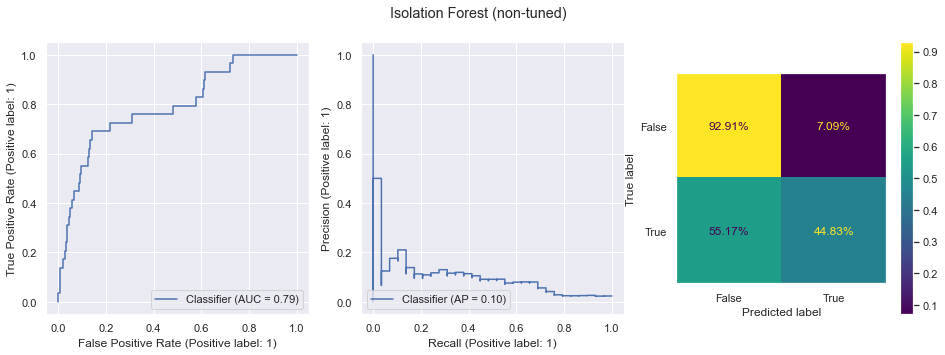

In [26]:
modelkey = "Isolation Forest"

model = IsolationForestWrapper().fit(X_train_if[~y_train_if].to_numpy())
Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test_if.to_numpy(),
    y_test_if,
    plot_title="Isolation Forest (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
)


X has feature names, but IsolationForestWrapper was fitted without feature names
X has feature names, but IsolationForestWrapper was fitted without feature names


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.646667,0.036789,0.758621,0.790359,0.070175,0.154062


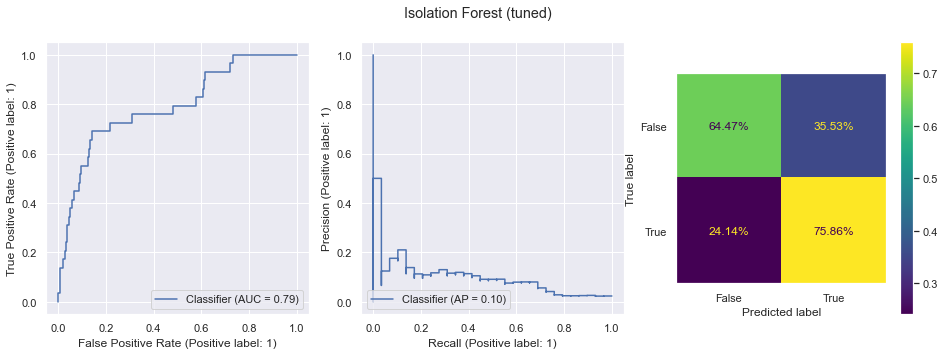

In [27]:
y_pred_proba_train = model.decision_function(X_train_if)
y_pred_proba_train -= y_pred_proba_train.min()

threshold = get_threshold(y_train_if, y_pred_proba_train,)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.decision_function(X_test_if)
y_pred = np.where(y_pred_proba - y_pred_proba.min() > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test_if,
    y_pred,
    y_pred_proba,
    plot_title="Isolation Forest (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_isolation_forest.png"
    if Notebook.SAVE_IMAGES
    else None,
)


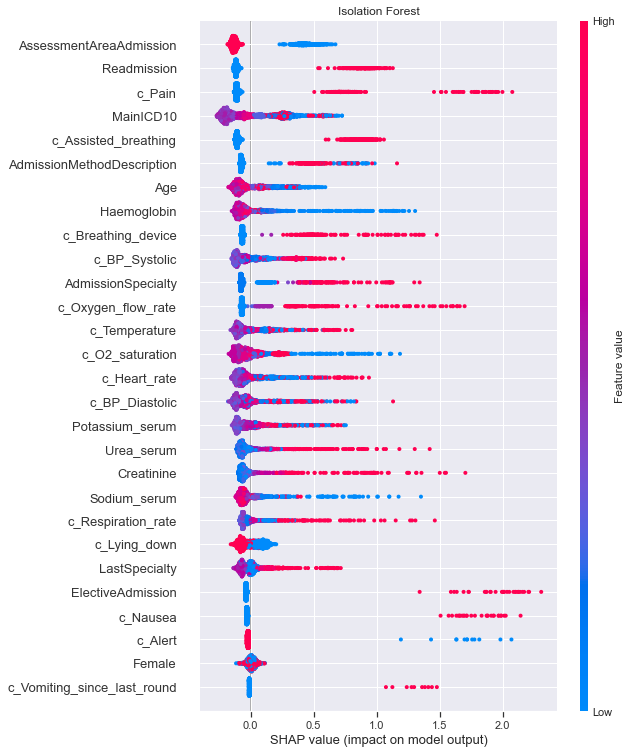

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_if)
shap_values.values = -shap_values.values  # Fix for isolation forest's unique labelling
Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

fig = shap.plots.beeswarm(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_isolation_forest.png", bbox_inches="tight"
    )



In [ ]:
fig = shap.plots.bar(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_isolation_forest.png", bbox_inches="tight"
    )



### TabNet


Early stopping occurred at epoch 111 with best_epoch = 61 and best_valid_F2 = 0.37634
Best weights from best epoch are automatically used!


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.980606,0.333333,0.103448,0.856772,0.157895,0.12


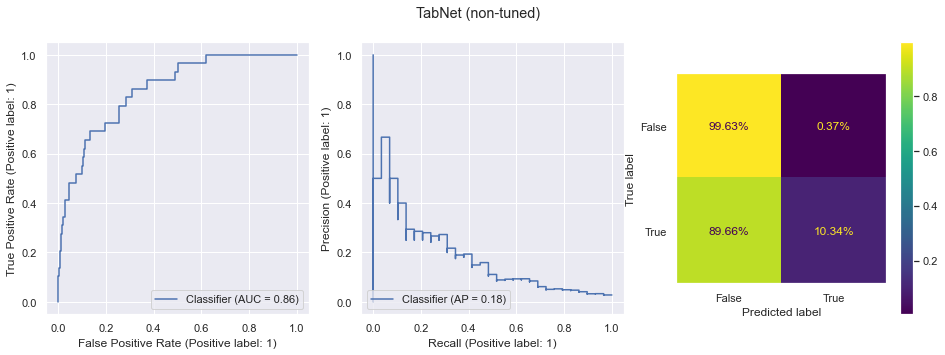

In [29]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    n_a=24,
    n_d=24,
    cat_idxs=categorical_cols_idx,
    cat_dims=categorical_cols_dims,
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.1),
    scheduler_params=dict(step_size=50, gamma=0.7),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax",
    verbose=0,
)

modelkey = "TabNet"
model = TabNetClassifier(**tabnet_params)
model.fit(
    X_train=X_train_tn,
    y_train=y_train_tn,
    eval_set=[(X_train_tn, y_train_tn), (X_valid_tn, y_valid_tn),],
    eval_name=["train", "valid"],
    eval_metric=[F2TabNet],
    max_epochs=300,
    patience=50,
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

Notebook.MODELS[modelkey] = model

Notebook.EVAL_RESULTS[modelkey] = evaluate(
    model,
    X_test.to_numpy(),
    y_test,
    "TabNet (non-tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_tabnet.png" if Notebook.SAVE_IMAGES else None,
)


,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,0.715758,0.047325,0.793103,0.856772,0.08932,0.19103


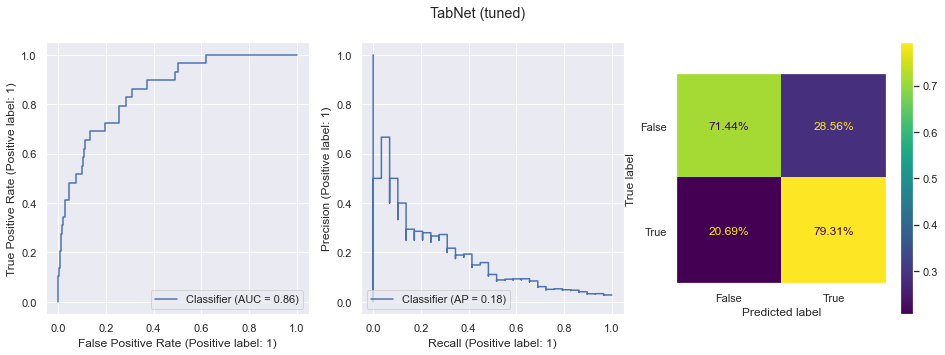

In [30]:
threshold = get_threshold(
    y_test, model.predict_proba(X_test.to_numpy())[:, 1], target=0.785
)

# Create predictions on the test set, using this new threshold
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred = np.where(y_pred_proba > threshold, 1, 0)

Notebook.TUNED_RESULTS[modelkey] = evaluate_from_pred(
    y_test,
    y_pred,
    y_pred_proba,
    plot_title="TabNet (tuned)",
    save=f"{Notebook.IMAGE_DIR}/eval_thresholded_tabnet.png"
    if Notebook.SAVE_IMAGES
    else None,
)


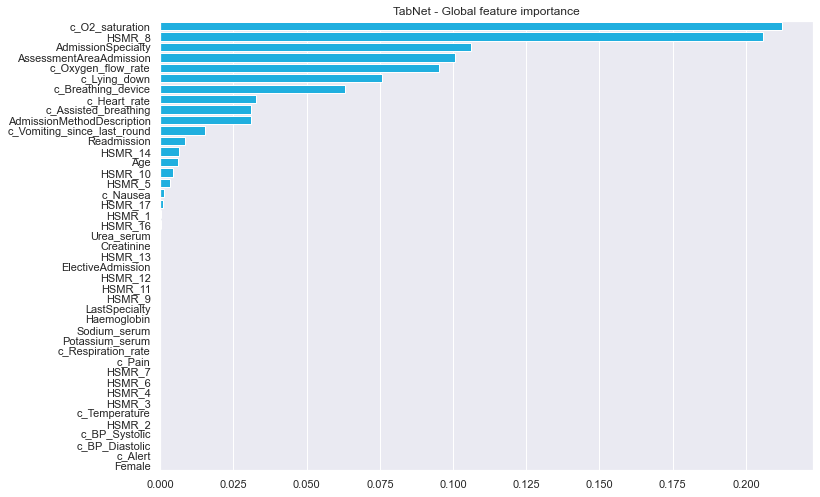

In [31]:
sorted_idx = model.feature_importances_.argsort()[::-1]
fig = sns.barplot(
    x=model.feature_importances_[sorted_idx],
    y=X_train.columns[sorted_idx],
    color="deepskyblue",
)
fig.set_title("TabNet - Global feature importance")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/global_weights_tabnet.png", bbox_inches="tight")



  0%|          | 0/1650 [00:00<?, ?it/s]

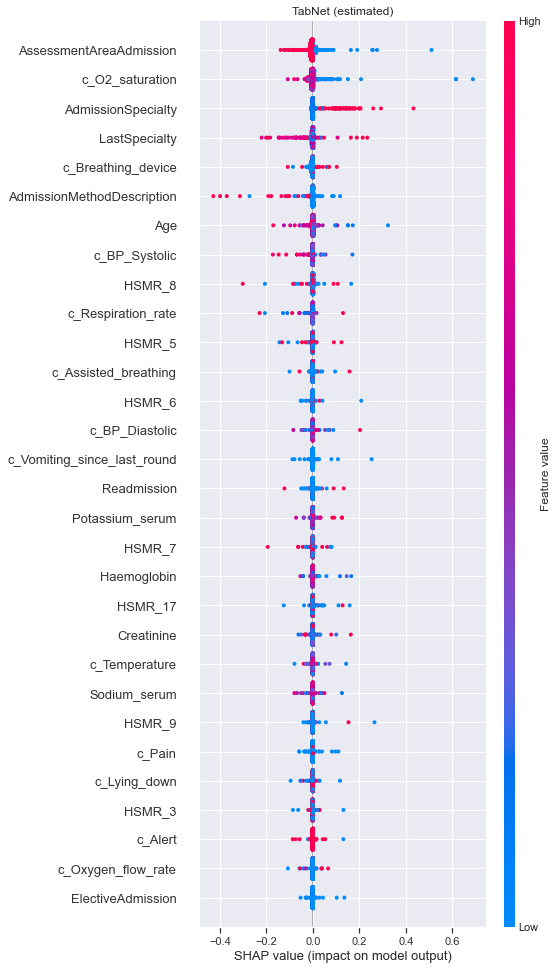

In [32]:
X_test_tn_shap = shap.sample(X_test.to_numpy(), 5000)
explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train_tn, 100))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(X_test_tn_shap, nsamples=50)

Notebook.EXPLAINERS[modelkey] = (explainer, shap_values)

shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type='dot'
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_tabnet.png", bbox_inches="tight")


In [ ]:
shap.summary_plot(
    shap_values[1],
    X_test_tn_shap,
    feature_names=X_test.columns,
    show=False,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    plot_type='bar'
)
plt.title("TabNet (estimated)")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_tabnet.png", bbox_inches="tight")

In [ ]:
fig = shap.plots.bar(shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False)
plt.title("Isolation Forest")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_isolation_forest.png", bbox_inches="tight"
    )

In [ ]:
if Notebook.SAVE_MODELS:
    with open(f'{Notebook.MODEL_DIR}/models.bin', 'wb') as file:
        pickle.dump(Notebook.MODELS, file)

    with open(f'{Notebook.MODEL_DIR}/explainers.bin', 'wb') as file:
        pickle.dump(Notebook.EXPLAINERS, file)

    with open(f'{Notebook.MODEL_DIR}/eval_results.bin', 'wb') as file:
        pickle.dump(Notebook.EVAL_RESULTS, file)

    with open(f'{Notebook.MODEL_DIR}/tuned_results.bin', 'wb') as file:
        pickle.dump(Notebook.TUNED_RESULTS, file)

    with open(f'{Notebook.MODEL_DIR}/sets.bin', 'wb') as file:
        pickle.dump((sci_train.index, sci_test.index), file)

## Comparisons

### Scores (pre-tuning)

In [33]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.EVAL_RESULTS.items()]
).set_index("Model")



,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,,,,,,
Baseline (NEWS),0.975758,0.176471,0.103448,0.722266,0.130435,0.112782
Logistic Regression (NEWS only),0.831515,0.056940,0.551724,0.724095,0.103226,0.201511
Logistic Regression,0.897576,0.102273,0.620690,0.880087,0.175610,0.308219
Random Forest,0.930303,0.109091,0.413793,0.883958,0.172662,0.265487
LightGBM,0.858182,0.071130,0.586207,0.852837,0.126866,0.239437
Isolation Forest,0.920606,0.101562,0.448276,0.790359,0.165605,0.266393
TabNet,0.980606,0.333333,0.103448,0.856772,0.157895,0.120000


### Scores (post-tuning)

In [34]:
pd.concat(
    [results[0].assign(Model=key) for key, results in Notebook.TUNED_RESULTS.items()]
).set_index("Model")



,Accuracy,Precision,Recall,AUC,F1 Score,F2 Score
Model,,,,,,
Logistic Regression (NEWS only),0.607273,0.028919,0.655172,0.724095,0.055394,0.122898
Logistic Regression,0.920606,0.113636,0.517241,0.880087,0.186335,0.302419
Random Forest,0.817576,0.075000,0.827586,0.883958,0.137536,0.275229
LightGBM,0.715152,0.050916,0.862069,0.852837,0.096154,0.205931
Isolation Forest,0.646667,0.036789,0.758621,0.790359,0.070175,0.154062
TabNet,0.715758,0.047325,0.793103,0.856772,0.089320,0.191030


### ROC

In [36]:
roc_dict, pr_dict = (
    {key: val[1] for key, val in Notebook.EVAL_RESULTS.items()},
    {key: val[2] for key, val in Notebook.EVAL_RESULTS.items()},
)



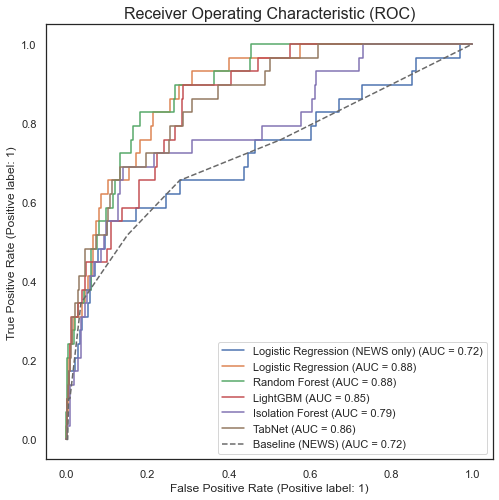

In [37]:
joint_plot(
    roc_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_roc_curve" if Notebook.SAVE_IMAGES else None,
    ax=None,
    title="Receiver Operating Characteristic (ROC)",
)


### Precision-Recall

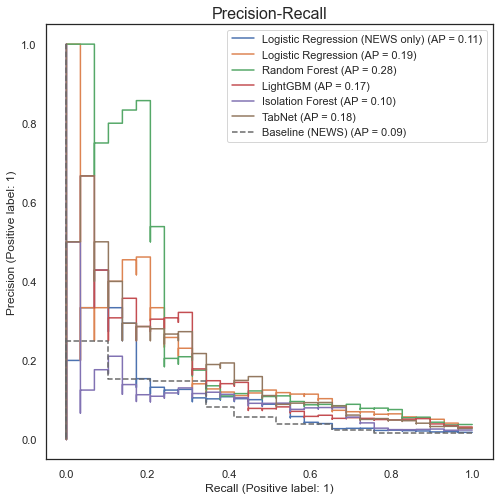

In [38]:
joint_plot(
    pr_dict,
    filename=f"{Notebook.IMAGE_DIR}/combined_pr_curve" if Notebook.SAVE_IMAGES else None,
    ax=None,
    title="Precision-Recall",
    legend_location="upper right",
)


### Side-by-side

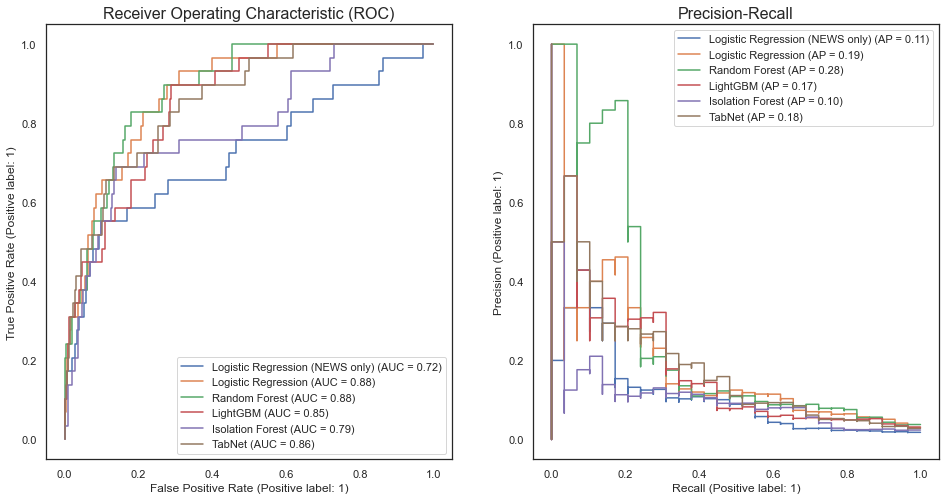

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict,
    ax=ax[1],
    title="Precision-Recall",
    legend_location="upper right",
    plot_baseline=False,
)
joint_plot(
    roc_dict,
    ax=ax[0],
    title="Receiver Operating Characteristic (ROC)",
    plot_baseline=False,
)

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/combined_curves_no_baseline.png", bbox_inches="tight"
    )



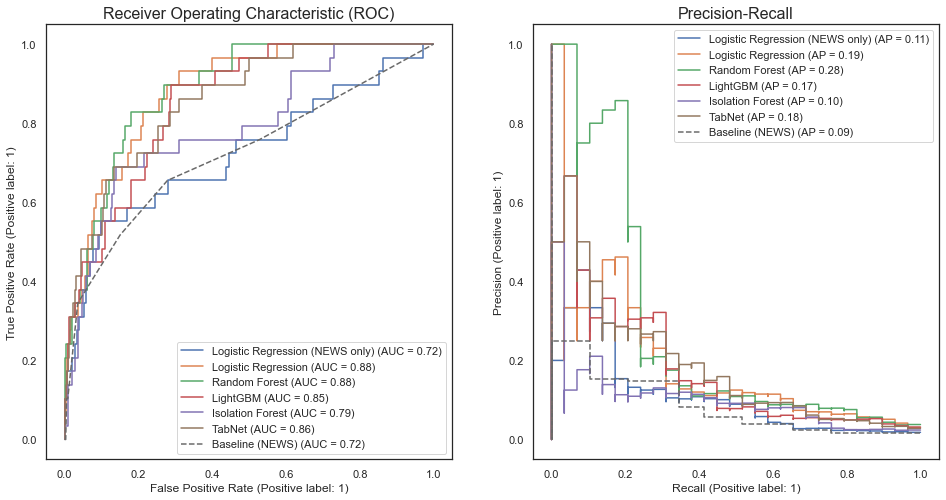

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
joint_plot(
    pr_dict, ax=ax[1], title="Precision-Recall", legend_location="upper right",
)
joint_plot(
    roc_dict, ax=ax[0], title="Receiver Operating Characteristic (ROC)",
)

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/combined_curves.png", bbox_inches="tight")


### SHAP Explanations (Setup - skip to next section)

In [47]:
y_preds = pd.DataFrame(
    {
        key: model.predict(
            {
                "LightGBM": X_test_lgbm,
                "Isolation Forest": X_test_if,
                "TabNet": X_test.to_numpy(),
                "XGBoost": X_test,
                "Random Forest": X_test,
                "Logistic Regression": X_test,
            }[key]
        )
        for key, model in Notebook.MODELS.items()
        if key != "Logistic Regression (NEWS only)"
    }
)

candidates = y_preds[y_preds.all(axis=1)].index

patient = candidates[0]
patient_data = X_test_lgbm.iloc[patient].apply(
    lambda x: f"{x:.2f}" if type(x) == np.float64 else x
)
patient_data_if = X_test_if.iloc[patient].copy()
patient_data_if.update(X_test_lgbm.iloc[patient])

explanations = {
    modelkey: shap_values[patient]
    for modelkey, (_, shap_values) in Notebook.EXPLAINERS.items()
    if not modelkey in ["TabNet", "Logistic Regression (NEWS only)"]
}
for _ in explanations.keys():
    if len(explanations[_].shape) > 1:
        explanations[_] = explanations[_][:, 1]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    tabnet_explainer = Notebook.EXPLAINERS["TabNet"][0]
    explanations["TabNet"] = shap.Explanation(
        tabnet_explainer.shap_values(X_test.to_numpy()[patient])[1],
        data=patient_data.values,
        base_values=tabnet_explainer.expected_value[1],
        feature_names=patient_data.index,
    )



X has feature names, but IsolationForestWrapper was fitted without feature names


### SHAP Force Plots

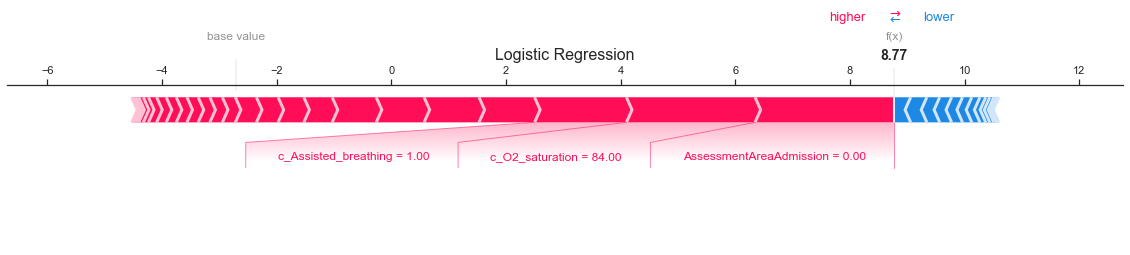

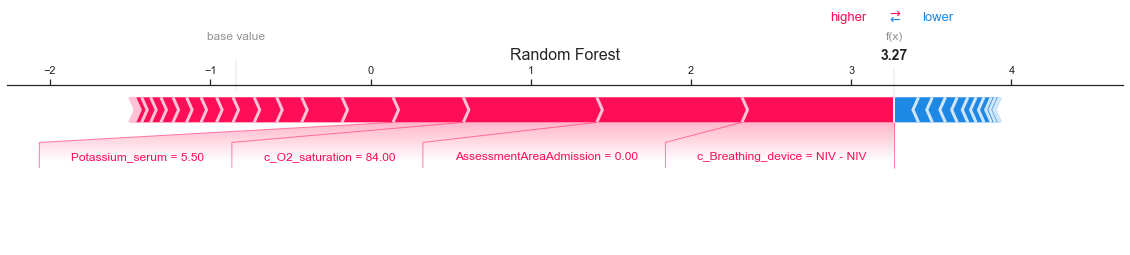

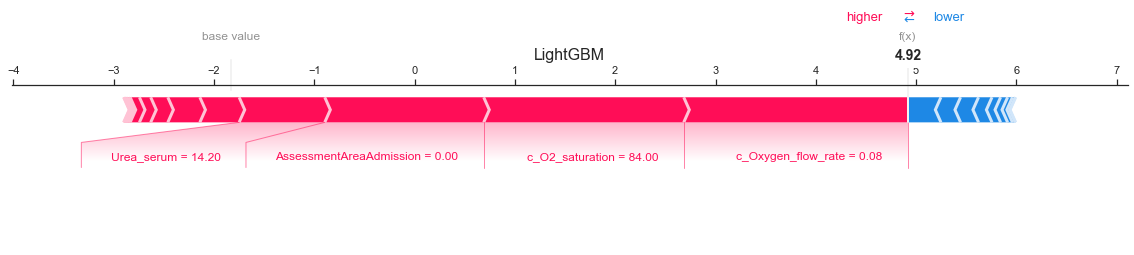

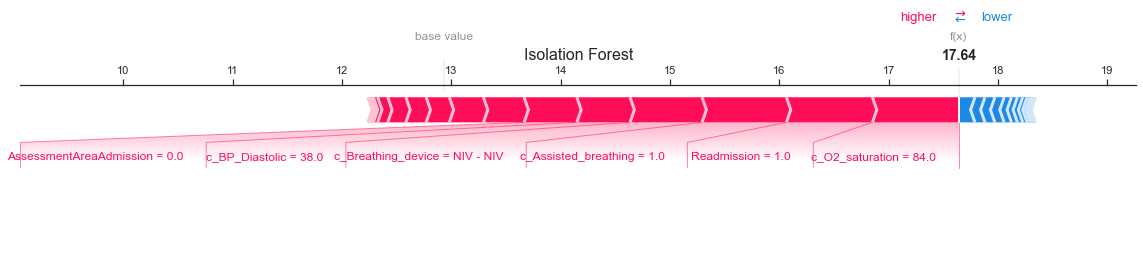

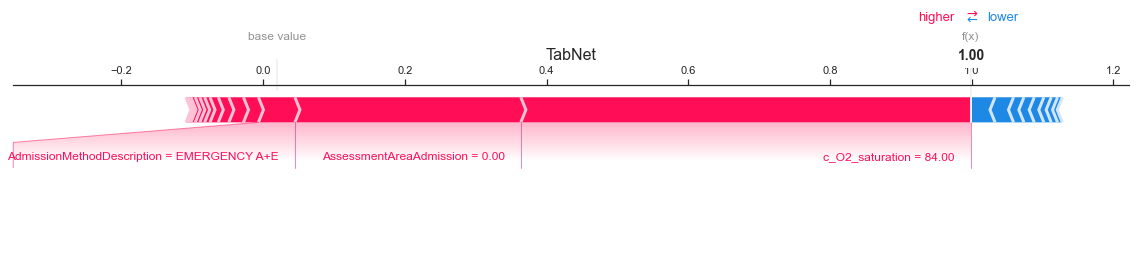

In [55]:
sns.set_style("white")
plt.rc("axes", titlesize=16)
for modelkey, explanation in explanations.items():
    patient_to_use = patient_data if modelkey != "Isolation Forest" else patient_data_if

    explanation = shap.Explanation(explanation)
    explanation.data = patient_to_use.values

    fig = shap.plots.force(
        explanation,
        feature_names=patient_to_use.index,
        matplotlib=True,
        contribution_threshold=0.08,
        show=False,
        text_rotation=15
    )

    plt.title(modelkey)
    display(fig)

    if Notebook.SAVE_IMAGES:
        plt.savefig(
            f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
            bbox_inches="tight",
        )

    plt.clf()
    
sns.set_style("darkgrid")

